In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

## Load data function

In [100]:
def read_csv_file(stock, date):
    dt = datetime.strptime(date, "%Y%m%d")
    year = dt.year
    month = dt.month

    def get_last_thursday(y, m):
        # Get last day of the month
        if m == 12:
            last_day = datetime(y + 1, 1, 1) - timedelta(days=1)
        else:
            last_day = datetime(y, m + 1, 1) - timedelta(days=1)
        offset = (last_day.weekday() - 3) % 7
        return last_day - timedelta(days=offset)

    # Determine relevant last Thursday
    last_thurs_current = get_last_thursday(year, month)

    if last_thurs_current < dt:
        # If current month's last Thursday is before the given date, go to next month
        if month == 12:
            next_month = 1
            next_year = year + 1
        else:
            next_month = month + 1
            next_year = year
        last_thurs = get_last_thursday(next_year, next_month)
    else:
        last_thurs = last_thurs_current

    last_thurs_str = last_thurs.strftime("%Y%m%d")

    file_paths = [
        f"{stock}/{year}/{year}_new/{stock}_{date}_{last_thurs_str}_Intraday_Preprocessed.csv",  
        f"{stock}/{year}/{stock}_{date}_{last_thurs_str}_Intraday_Preprocessed.csv",            
        f"{stock}/{year}_new/{stock}_{date}_{last_thurs_str}_Intraday_Preprocessed.csv",        
    ]

    for file_path in file_paths:
        if os.path.exists(file_path):
            return pd.read_csv(file_path)

    print("File not found in any of the expected locations:")
    for path in file_paths:
        print("  " + path)

    return None

def load_stock_data(stocks, date):
    data = []
    for stock in stocks:
        df = read_csv_file(stock, date)
        if df is None:
            raise FileNotFoundError(f"Data missing for stock: {stock}")
        data.append(df)
    return data

## Realistic backtest (with ask and bid)

In [122]:
def simulate_hedged_straddle_day(
    dfs,                  # list of DataFrames for each stock
    stocks,
    weights,
    start_date,
    hedge_interval_minutes,
    lot_sizes,            # list of lot sizes per stock, e.g. [75, 125]
    strategy="H1",        # "H1" for Single Stock Approach, "H2" for Portfolio Approach
    r=0.06,
    dividend_yield=0.0,
    cash=1_000_000,
    transaction_cost_per_unit=0.0,  # cost per option contract traded
    option_transaction_cost=0.0     # cost per option contract for straddles
):
    processed_dfs = []
    for df in dfs:
        df = df.rename(columns={'Date Time': 'Timestamp'})
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        if 'Instrument' in df.columns:
            df['Stock'] = df['Instrument']
        else:
            raise ValueError("Each input df must have 'Instrument' column for stock name")
        processed_dfs.append(df)

    df_all_stocks = pd.concat(processed_dfs, ignore_index=True)
    index_cols = ['Timestamp', 'Stock', 'Strike', 'Type']
    df_all_stocks.set_index(index_cols, inplace=True)
    df_all_stocks.sort_index(inplace=True)

    df = df_all_stocks[df_all_stocks.index.get_level_values('Timestamp').date == pd.to_datetime(start_date).date()]

    # Hedge times
    start_time = pd.to_datetime(str(start_date) + ' 09:20:00')
    end_time = pd.to_datetime(str(start_date) + ' 15:15:00')
    hedge_times = pd.date_range(start=start_time, end=end_time, freq=f'{hedge_interval_minutes}min')

    # Helper to find closest timestamp in df for a given target_time
    def get_closest_timestamp(target_time):
        timestamps = df.index.get_level_values('Timestamp').unique()
        if len(timestamps) == 0:
            raise ValueError("No timestamps available in dataframe.")
        if target_time <= timestamps[0]:
            return timestamps[0]
        if target_time >= timestamps[-1]:
            return timestamps[-1]
        idx = timestamps.get_indexer([target_time], method='ffill')[0]
        return timestamps[idx]

    # Initialize portfolio - key addition: track straddle positions
    if strategy == "H1":
        hedge_positions = {stock: 0.0 for stock in stocks}  # Individual stock positions
    elif strategy == "H2":
        hedge_positions = {stock: 0.0 for stock in stocks}  # Portfolio hedge distributed across stocks
    else:
        raise ValueError("Strategy must be 'H1' or 'H2'")
        
    straddle_positions = {stock: {'quantity': 0, 'strike': 0, 'entry_price': 0} for stock in stocks}
    cash = float(cash)
    pnl_records = []
    initial_cash = cash

    if len(lot_sizes) != len(stocks):
        raise ValueError("lot_sizes length must match stocks length")

    # STEP 1: Initial straddle purchase at first hedge time
    first_time = hedge_times[0]
    actual_first_time = get_closest_timestamp(first_time)
    
    for i, (stock, weight) in enumerate(zip(stocks, weights)):
        lot = lot_sizes[i]
        try:
            df_stock = df.xs(stock, level='Stock')
            spot = df_stock.xs(actual_first_time, level='Timestamp')['Spot'].iloc[0]
            strikes = df_stock.index.get_level_values('Strike').unique()
            atm_strike = strikes[np.abs(strikes - spot).argmin()]

            # Get initial straddle prices - BUY at ASK price
            ce_ask_price = float(df.loc[(actual_first_time, stock, atm_strike, 'CE'), 'AskPrice'])
            pe_ask_price = float(df.loc[(actual_first_time, stock, atm_strike, 'PE'), 'AskPrice'])
            
            # Calculate position size based on weight
            straddle_quantity = int(lot * weight)
            straddle_cost = (ce_ask_price + pe_ask_price) * straddle_quantity
            
            # Buy straddle
            cash -= straddle_cost
            cash -= straddle_quantity * option_transaction_cost  # Transaction cost
            
            # Record position
            straddle_positions[stock] = {
                'quantity': straddle_quantity,
                'strike': atm_strike,
                'entry_price': ce_ask_price + pe_ask_price
            }
            
            print(f"Initial: Bought {straddle_quantity} {stock} straddles at strike {atm_strike} for {straddle_cost:.2f}")
            
        except Exception as e:
            print(f"Error buying initial straddle for {stock}: {e}")
            continue

    # STEP 2: Regular hedging loop
    for current_time in hedge_times:
        actual_time = get_closest_timestamp(current_time)
        option_values = []
        total_deltas = []

        for i, (stock, weight) in enumerate(zip(stocks, weights)):
            lot = lot_sizes[i]
            try:
                if straddle_positions[stock]['quantity'] == 0:
                    option_values.append(0.0)
                    total_deltas.append(0.0)
                    continue
                    
                strike = straddle_positions[stock]['strike']
                quantity = straddle_positions[stock]['quantity']

                # Get current option prices for valuation (use mid_price for mark-to-market)
                ce_mid_price = float(df.loc[(actual_time, stock, strike, 'CE'), 'mid_price'])
                pe_mid_price = float(df.loc[(actual_time, stock, strike, 'PE'), 'mid_price'])
                ce_delta = float(df.loc[(actual_time, stock, strike, 'CE'), 'Delta'])
                pe_delta = float(df.loc[(actual_time, stock, strike, 'PE'), 'Delta'])

                # Current value of our straddle position (mark-to-market at mid)
                straddle_value = (ce_mid_price + pe_mid_price) * quantity
                
                # Total delta for our position
                total_delta = (ce_delta + pe_delta) * quantity

                option_values.append(straddle_value)
                total_deltas.append(total_delta)
                
            except Exception as e:
                print(f"Error processing {stock} at {actual_time}: {e}")
                option_values.append(0.0)
                total_deltas.append(0.0)
                continue

        # Hedge adjustment based on strategy
        if strategy == "H1":
            # H1: Single Stock Approach - hedge each stock individually
            for i, (stock, weight) in enumerate(zip(stocks, weights)):
                if straddle_positions[stock]['quantity'] == 0:
                    continue
                    
                old_pos = hedge_positions[stock]
                required_hedge = -total_deltas[i]  # -w_j*d^t_j for stock j
                trade_qty = required_hedge - old_pos
                
                if abs(trade_qty) > 0.0:  # Only trade if meaningful change
                    trade_cost = abs(trade_qty) * transaction_cost_per_unit
                    cash -= trade_cost

                    try:
                        spot_price = df.xs((actual_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
                        
                        # Use bid/ask for realistic execution
                        if trade_qty > 0:  # Buying stock - pay ask price
                            # Assumption spot price is mid, add half spread
                            execution_price = spot_price * 1.0005  # Approximate 0.05% spread
                        else:  # Selling stock - receive bid price
                            execution_price = spot_price * 0.9995
                            
                        cash -= trade_qty * execution_price
                        hedge_positions[stock] = required_hedge
                    except Exception as e:
                        print(f"Error hedging {stock}: {e}")
                        
        elif strategy == "H2":
            # H2: Portfolio Approach - calculate total portfolio delta and distribute hedge
            total_portfolio_delta = sum(total_deltas)  # OD^t = sum of all deltas
            
            if abs(total_portfolio_delta) > 0.01:  # Only hedge if meaningful portfolio delta
                # Calculate total portfolio hedge needed: -OD^t * sum(w_i * F_i)
                # Since we're using spot prices, we distribute the hedge proportionally by weight
                total_portfolio_hedge = -total_portfolio_delta
                
                # Get current total hedge position
                current_total_hedge = sum(hedge_positions.values())
                total_trade_qty = total_portfolio_hedge - current_total_hedge
                
                if abs(total_trade_qty) > 0.0:
                    # Distribute the portfolio hedge proportionally across stocks by weight
                    for i, (stock, weight) in enumerate(zip(stocks, weights)):
                        if straddle_positions[stock]['quantity'] == 0:
                            continue
                            
                        # Calculate this stock's portion of the portfolio hedge
                        stock_hedge_portion = total_portfolio_hedge * weight
                        old_pos = hedge_positions[stock]
                        trade_qty = stock_hedge_portion - old_pos
                        
                        if abs(trade_qty) > 0.01:
                            trade_cost = abs(trade_qty) * transaction_cost_per_unit
                            cash -= trade_cost

                            try:
                                spot_price = df.xs((actual_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
                                
                                # Use bid/ask for realistic execution
                                if trade_qty > 0:  # Buying stock - pay ask price
                                    execution_price = spot_price * 1.0005  # Approximate 0.05% spread
                                else:  # Selling stock - receive bid price
                                    execution_price = spot_price * 0.9995
                                    
                                cash -= trade_qty * execution_price
                                hedge_positions[stock] = stock_hedge_portion
                            except Exception as e:
                                print(f"Error hedging {stock} in H2: {e}")

        # Calculate portfolio values (use mid prices for mark-to-market)
        option_value_total = sum(option_values)
        hedge_value = 0.0
        
        for stock in stocks:
            if hedge_positions[stock] != 0:
                try:
                    # Use mid price (spot) for mark-to-market valuation of hedge positions
                    spot_price = df.xs((actual_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
                    hedge_value += hedge_positions[stock] * spot_price
                except:
                    pass

        total_portfolio_value = option_value_total + hedge_value + cash

        pnl_records.append({
            "Timestamp": current_time,
            "OptionValue": option_value_total,
            "HedgeValue": hedge_value,
            "Cash": cash,
            "TotalValue": total_portfolio_value,
            "PnL": total_portfolio_value - initial_cash,
            "Strategy": strategy,
            "TotalPortfolioDelta": sum(total_deltas) if strategy == "H2" else None
        })

    # STEP 3: End-of-day unwind - sell all positions
    final_time = hedge_times[-1]
    actual_final_time = get_closest_timestamp(final_time)
    total_itm_loss = 0.0

    for i, stock in enumerate(stocks):
        if straddle_positions[stock]['quantity'] == 0:
            continue
            
        quantity = straddle_positions[stock]['quantity']
        strike = straddle_positions[stock]['strike']
        
        try:
            # Get final spot price
            spot = df.xs((actual_final_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
            
            # Get final option prices - SELL at BID price
            ce_bid_price = float(df.loc[(actual_final_time, stock, strike, 'CE'), 'BidPrice'])
            pe_bid_price = float(df.loc[(actual_final_time, stock, strike, 'PE'), 'BidPrice'])
            
            # Sell the straddles at bid prices
            straddle_proceeds = (ce_bid_price + pe_bid_price) * quantity
            cash += straddle_proceeds
            cash -= quantity * option_transaction_cost  # Transaction cost for selling
            
            # Calculate ITM loss (intrinsic value lost)
            if spot > strike:
                # Call is ITM
                itm_value = max(0, spot - strike) * quantity
                total_itm_loss += itm_value
            elif spot < strike:
                # Put is ITM
                itm_value = max(0, strike - spot) * quantity
                total_itm_loss += itm_value
            
            print(f"Final: Sold {quantity} {stock} straddles for {straddle_proceeds:.2f}, ITM loss: {itm_value if spot != strike else 0:.2f}")
            
        except Exception as e:
            print(f"Error unwinding {stock}: {e}")

        # Close hedge position
        old_hedge_pos = hedge_positions[stock]
        if abs(old_hedge_pos) > 0.01:
            try:
                spot_price = df.xs((actual_final_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
                
                # Use bid/ask for realistic execution when closing hedge
                if old_hedge_pos > 0:  # Selling long stock position - receive bid price
                    execution_price = spot_price * 0.9995
                else:  # Covering short stock position - pay ask price
                    execution_price = spot_price * 1.0005
                    
                cash += old_hedge_pos * execution_price
                hedge_positions[stock] = 0.0
            except Exception as e:
                print(f"Error closing hedge for {stock}: {e}")

    final_portfolio_value = cash
    total_pnl = final_portfolio_value - initial_cash

    pnl_df = pd.DataFrame(pnl_records)
    final_report = {
        "initial_cash": initial_cash,
        "final_cash": cash,
        "total_pnl": total_pnl,
        "total_itm_loss": total_itm_loss,
        "strategy_used": strategy
    }

    return pnl_df, final_portfolio_value, final_report

## Backtesting function (with midprice)

In [ ]:
def simulate_hedged_straddle_day(
    dfs,                  # list of DataFrames for each stock
    stocks,
    weights,
    start_date,
    hedge_interval_minutes,
    lot_sizes,            # list of lot sizes per stock,
    strategy="H1",        # "H1" for Single Stock Approach, "H2" for Portfolio Approach
    r=0.06,
    dividend_yield=0.0,
    cash=1_000_000,
    transaction_cost_per_unit=0.0,  # cost per option contract traded
    option_transaction_cost=0.0     # cost per option contract for straddles
):
    # Prepare combined df_all_stocks with correct indexing and sorting
    processed_dfs = []
    for df in dfs:
        df = df.rename(columns={'Date Time': 'Timestamp'})
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        if 'Instrument' in df.columns:
            df['Stock'] = df['Instrument']
        else:
            raise ValueError("Each input df must have 'Instrument' column for stock name")
        processed_dfs.append(df)

    df_all_stocks = pd.concat(processed_dfs, ignore_index=True)
    index_cols = ['Timestamp', 'Stock', 'Strike', 'Type']
    df_all_stocks.set_index(index_cols, inplace=True)
    df_all_stocks.sort_index(inplace=True)

    df = df_all_stocks[df_all_stocks.index.get_level_values('Timestamp').date == pd.to_datetime(start_date).date()]

    # Hedge times
    start_time = pd.to_datetime(str(start_date) + ' 09:15:00')
    end_time = pd.to_datetime(str(start_date) + ' 15:15:00')
    hedge_times = pd.date_range(start=start_time, end=end_time, freq=f'{hedge_interval_minutes}min')

    # Helper to find closest timestamp in df for a given target_time
    def get_closest_timestamp(target_time):
        timestamps = df.index.get_level_values('Timestamp').unique()
        if len(timestamps) == 0:
            raise ValueError("No timestamps available in dataframe.")
        if target_time <= timestamps[0]:
            return timestamps[0]
        if target_time >= timestamps[-1]:
            return timestamps[-1]
        idx = timestamps.get_indexer([target_time], method='ffill')[0]
        return timestamps[idx]

    # Initialize portfolio - key addition: track straddle positions
    if strategy == "H1":
        hedge_positions = {stock: 0.0 for stock in stocks}  # Individual stock positions
    elif strategy == "H2":
        hedge_positions = {stock: 0.0 for stock in stocks}  # Portfolio hedge distributed across stocks
    else:
        raise ValueError("Strategy must be 'H1' or 'H2'")
        
    straddle_positions = {stock: {'quantity': 0, 'strike': 0, 'entry_price': 0} for stock in stocks}
    cash = float(cash)
    pnl_records = []
    initial_cash = cash

    if len(lot_sizes) != len(stocks):
        raise ValueError("lot_sizes length must match stocks length")

    # STEP 1: Initial straddle purchase at first hedge time
    first_time = hedge_times[0]
    actual_first_time = get_closest_timestamp(first_time)
    
    for i, (stock, weight) in enumerate(zip(stocks, weights)):
        lot = lot_sizes[i]
        try:
            df_stock = df.xs(stock, level='Stock')
            spot = df_stock.xs(actual_first_time, level='Timestamp')['Spot'].iloc[0]
            strikes = df_stock.index.get_level_values('Strike').unique()
            sorted_strikes = sorted(strikes, key=lambda x: abs(x - spot))  

            # Find the first strike that has both CE and PE
            atm_strike = None
            for strike in sorted_strikes:
                ce_key = (actual_first_time, stock, strike, 'CE')
                pe_key = (actual_first_time, stock, strike, 'PE')
                if ce_key in df.index and pe_key in df.index:
                    atm_strike = strike
                    break

            if atm_strike is None:
                print(f"Skipping {stock}: No ATM strike with both CE and PE available at {actual_first_time}")
                continue  

            # Get initial straddle prices
            ce_price = float(df.loc[(actual_first_time, stock, atm_strike, 'CE'), 'mid_price'])
            pe_price = float(df.loc[(actual_first_time, stock, atm_strike, 'PE'), 'mid_price'])

            
            # Calculate position size based on weight
            straddle_quantity = int(lot * weight)
            straddle_cost = (ce_price + pe_price) * straddle_quantity
            
            # Buy straddle
            cash -= straddle_cost
            cash -= straddle_quantity * option_transaction_cost  # Transaction cost
            
            # Record position
            straddle_positions[stock] = {
                'quantity': straddle_quantity,
                'strike': atm_strike,
                'entry_price': ce_price + pe_price
            }
            
            print(f"Initial: Bought {straddle_quantity} {stock} straddles at strike {atm_strike} for {straddle_cost:.2f}")
            
        except Exception as e:
            print(f"Error buying initial straddle for {stock}: {e}")
            continue

    # STEP 2: Regular hedging loop
    for current_time in hedge_times:
        actual_time = get_closest_timestamp(current_time)
        option_values = []
        total_deltas = []

        for i, (stock, weight) in enumerate(zip(stocks, weights)):
            lot = lot_sizes[i]
            try:
                if straddle_positions[stock]['quantity'] == 0:
                    option_values.append(0.0)
                    total_deltas.append(0.0)
                    continue
                    
                strike = straddle_positions[stock]['strike']
                quantity = straddle_positions[stock]['quantity']

                # Get current option prices and deltas for the specific strike we own
                ce_price = float(df.loc[(actual_time, stock, strike, 'CE'), 'mid_price'])
                pe_price = float(df.loc[(actual_time, stock, strike, 'PE'), 'mid_price'])
                ce_delta = float(df.loc[(actual_time, stock, strike, 'CE'), 'Delta'])
                pe_delta = float(df.loc[(actual_time, stock, strike, 'PE'), 'Delta'])

                # Current value of our straddle position
                straddle_value = (ce_price + pe_price) * quantity
                
                # Total delta for our position
                total_delta = (ce_delta + pe_delta) * quantity

                option_values.append(straddle_value)
                total_deltas.append(total_delta)
                
            except Exception as e:
                print(f"Error processing {stock} at {actual_time}: {e}")
                option_values.append(0.0)
                total_deltas.append(0.0)
                continue

        # Hedge adjustment based on strategy
        if strategy == "H1":
            # H1: Single Stock Approach - hedge each stock individually
            for i, (stock, weight) in enumerate(zip(stocks, weights)):
                if straddle_positions[stock]['quantity'] == 0:
                    continue
                    
                old_pos = hedge_positions[stock]
                required_hedge = -total_deltas[i]  # -w_j*d^t_j for stock j
                trade_qty = required_hedge - old_pos
                
                if abs(trade_qty) > 0.01:  # Only trade if meaningful change
                    trade_cost = abs(trade_qty) * transaction_cost_per_unit
                    cash -= trade_cost

                    try:
                        spot_price = df.xs((actual_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
                        cash -= trade_qty * spot_price  # Buy/sell stock
                        hedge_positions[stock] = required_hedge
                    except Exception as e:
                        print(f"Error hedging {stock}: {e}")
                        
        elif strategy == "H2":
            # H2: Portfolio Approach - calculate total portfolio delta and distribute hedge
            total_portfolio_delta = sum(total_deltas)  # OD^t = sum of all deltas
            
            if abs(total_portfolio_delta) > 0.01:  # Only hedge if meaningful portfolio delta
                # Calculate total portfolio hedge needed: -OD^t * sum(w_i * F_i)
                # Since we're using spot prices, we distribute the hedge proportionally by weight
                total_portfolio_hedge = -total_portfolio_delta
                
                # Get current total hedge position
                current_total_hedge = sum(hedge_positions.values())
                total_trade_qty = total_portfolio_hedge - current_total_hedge
                
                if abs(total_trade_qty) > 0.01:
                    # Distribute the portfolio hedge proportionally across stocks by weight
                    for i, (stock, weight) in enumerate(zip(stocks, weights)):
                        if straddle_positions[stock]['quantity'] == 0:
                            continue
                            
                        # Calculate this stock's portion of the portfolio hedge
                        stock_hedge_portion = total_portfolio_hedge * weight
                        old_pos = hedge_positions[stock]
                        trade_qty = stock_hedge_portion - old_pos
                        
                        if abs(trade_qty) > 0.01:
                            trade_cost = abs(trade_qty) * transaction_cost_per_unit
                            cash -= trade_cost

                            try:
                                spot_price = df.xs((actual_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
                                cash -= trade_qty * spot_price  # Buy/sell stock
                                hedge_positions[stock] = stock_hedge_portion
                            except Exception as e:
                                print(f"Error hedging {stock} in H2: {e}")

        # Calculate portfolio values
        option_value_total = sum(option_values)
        hedge_value = 0.0
        
        for stock in stocks:
            if hedge_positions[stock] != 0:
                try:
                    spot_price = df.xs((actual_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
                    hedge_value += hedge_positions[stock] * spot_price
                except:
                    pass

        total_portfolio_value = option_value_total + hedge_value + cash

        pnl_records.append({
            "Timestamp": current_time,
            "OptionValue": option_value_total,
            "HedgeValue": hedge_value,
            "Cash": cash,
            "TotalValue": total_portfolio_value,
            "PnL": total_portfolio_value - initial_cash,
            "Strategy": strategy,
            "TotalPortfolioDelta": sum(total_deltas) if strategy == "H2" else None
        })

    # STEP 3: End-of-day unwind - sell all positions
    final_time = hedge_times[-1]
    actual_final_time = get_closest_timestamp(final_time)
    total_itm_loss = 0.0

    for i, stock in enumerate(stocks):
        if straddle_positions[stock]['quantity'] == 0:
            continue
            
        quantity = straddle_positions[stock]['quantity']
        strike = straddle_positions[stock]['strike']
        
        try:
            # Final spot price
            spot = df.xs((actual_final_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
            
            # Final option prices
            ce_price = float(df.loc[(actual_final_time, stock, strike, 'CE'), 'mid_price'])
            pe_price = float(df.loc[(actual_final_time, stock, strike, 'PE'), 'mid_price'])
            
            # Sell the straddles
            straddle_proceeds = (ce_price + pe_price) * quantity
            cash += straddle_proceeds
            cash -= quantity * option_transaction_cost  # Transaction cost for selling
            
            # Calculate ITM loss (intrinsic value lost)
            if spot > strike:
                # Call is ITM
                itm_value = max(0, spot - strike) * quantity
                total_itm_loss += itm_value
            elif spot < strike:
                # Put is ITM
                itm_value = max(0, strike - spot) * quantity
                total_itm_loss += itm_value
            
            print(f"Final: Sold {quantity} {stock} straddles for {straddle_proceeds:.2f}, ITM loss: {itm_value if spot != strike else 0:.2f}")
            
        except Exception as e:
            print(f"Error unwinding {stock}: {e}")

        # Close hedge position
        old_hedge_pos = hedge_positions[stock]
        if abs(old_hedge_pos) > 0.01:
            try:
                spot_price = df.xs((actual_final_time, stock), level=('Timestamp', 'Stock'))['Spot'].iloc[0]
                cash += old_hedge_pos * spot_price  # Close hedge position
                hedge_positions[stock] = 0.0
            except Exception as e:
                print(f"Error closing hedge for {stock}: {e}")

    final_portfolio_value = cash
    total_pnl = final_portfolio_value - initial_cash

    pnl_df = pd.DataFrame(pnl_records)
    final_report = {
        "initial_cash": initial_cash,
        "final_cash": cash,
        "total_pnl": total_pnl,
        "total_itm_loss": total_itm_loss,
        "strategy_used": strategy
    }

    return pnl_df, final_portfolio_value, final_report

## Use case

In [97]:
S_1 = read_csv_file(stocks[0], start_date)
# S_2 = read_csv_file(stocks[1], start_date)
# S_3 = read_csv_file(stocks[2], start_date)

In [98]:
S_1.columns

Index(['Date Time', 'ExchToken', 'BidPrice', 'BidQty', 'AskPrice', 'AskQty',
       'TTq', 'LTP', 'TotalTradedPrice', 'Instrument', 'ExpiryDate',
       'ExpiryTime', 'Strike', 'Type', 'ExpiryDateTime', 'Spot',
       'Time_to_expire', 'Delta', 'Theta', 'Gamma', 'Vega', 'Sigma',
       'bid_ask_spread', 'mid_price', 'Intrinsic_value', 'bid_ask_move',
       'price_problem', 'is_tradable', 'bid_plus', 'ask_minus'],
      dtype='object')

In [123]:
stocks = ["TATAMOTORS", "TCS", "TITAN"] # Available "ASIANPAINT", "BAJAJ-AUTO", "BAJFINANCE", "HDFCBANK", "ICICIBANK", "RELIANCE", "SBIN", "TATAMOTORS", "TCS", "TITAN"
weight = [1/len(stocks)] * len(stocks) # weights for the assets
start_date = "20240101"

# Lot_sizes
df = pd.read_csv('NIFTY_200_Lot_Size.csv')
df['Symbol'] = df['Symbol'].str.strip().str.upper()
df['LOT_SIZE'] = pd.to_numeric(df['LOT_SIZE'], errors='coerce')

lot_sizes = []

for symbol in stocks:
    symbol = symbol.strip().upper()
    lot_size_row = df[df['Symbol'] == symbol]

    if not lot_size_row.empty:
        lot_size = lot_size_row['LOT_SIZE'].values[0]
    else:
        lot_size = None

    lot_sizes.append(lot_size)

In [127]:
pnl_df, total_value, final_report = simulate_hedged_straddle_day(
    load_stock_data(stocks, start_date),  
    stocks=stocks,
    weights=weight,
    start_date=start_date,
    hedge_interval_minutes=5,
    lot_sizes=lot_sizes,
    strategy="H2",
    r=0.06,
    dividend_yield=0.0,
    cash=1000000,
    transaction_cost_per_unit=0.0,
    option_transaction_cost=0.0
)

Initial: Bought 183 TATAMOTORS straddles at strike 795.0 for 10028.40
Initial: Bought 58 TCS straddles at strike 3800.0 for 12472.90
Initial: Bought 58 TITAN straddles at strike 3700.0 for 11049.00
Final: Sold 183 TATAMOTORS straddles for 9406.20, ITM loss: 60.39
Final: Sold 58 TCS straddles for 12252.50, ITM loss: 1856.00
Final: Sold 58 TITAN straddles for 10422.60, ITM loss: 328.86


In [129]:
print("Final Total Portfolio Value:", total_value)
print("\nFinal Report:")
for key, value in final_report.items():
    print(f"{key}: {value}")

print(pnl_df.tail())

Final Total Portfolio Value: 998199.3830976387

Final Report:
initial_cash: 1000000.0
final_cash: 998199.3830976387
total_pnl: -1800.6169023612747
total_itm_loss: 2245.250000000012
strategy_used: H2
             Timestamp  OptionValue    HedgeValue          Cash  \
67 2024-01-01 14:55:00    32495.475 -99373.407993  1.065044e+06   
68 2024-01-01 15:00:00    32512.775 -96950.041149  1.062666e+06   
69 2024-01-01 15:05:00    32334.275 -80398.660278  1.046296e+06   
70 2024-01-01 15:10:00    32250.175 -70375.048994  1.036379e+06   
71 2024-01-01 15:15:00    32207.575 -51458.252336  1.017602e+06   

       TotalValue          PnL Strategy  TotalPortfolioDelta  
67  998165.607896 -1834.392104       H2            35.563917  
68  998229.019872 -1770.980128       H2            34.713161  
69  998231.409736 -1768.590264       H2            28.843155  
70  998254.457711 -1745.542289       H2            25.282420  
71  998351.387224 -1648.612776       H2            18.525712  


In [116]:
pnl_df

,Timestamp,OptionValue,HedgeValue,Cash,TotalValue,PnL,Strategy,TotalPortfolioDelta
0,2024-01-01 09:20:00,33419.225,-26083.472266,9.925201e+05,999855.883264,-144.116736,H2,9.432682
1,2024-01-01 09:25:00,33177.150,-28934.258199,9.953422e+05,999585.136050,-414.863950,H2,10.452700
2,2024-01-01 09:30:00,33199.125,-28472.257083,9.948951e+05,999622.009183,-377.990817,H2,10.291177
3,2024-01-01 09:35:00,33139.825,-51013.436514,1.017410e+06,999536.592421,-463.407579,H2,18.428977
4,2024-01-01 09:40:00,33126.350,-46747.151550,1.013193e+06,999572.119531,-427.880469,H2,16.904687
...,...,...,...,...,...,...,...,...
67,2024-01-01 14:55:00,32495.475,-99373.407993,1.065044e+06,998165.607896,-1834.392104,H2,35.563917
68,2024-01-01 15:00:00,32512.775,-96950.041149,1.062666e+06,998229.019872,-1770.980128,H2,34.713161
69,2024-01-01 15:05:00,32334.275,-80398.660278,1.046296e+06,998231.409736,-1768.590264,H2,28.843155
70,2024-01-01 15:10:00,32250.175,-70375.048994,1.036379e+06,998254.457711,-1745.542289,H2,25.282420


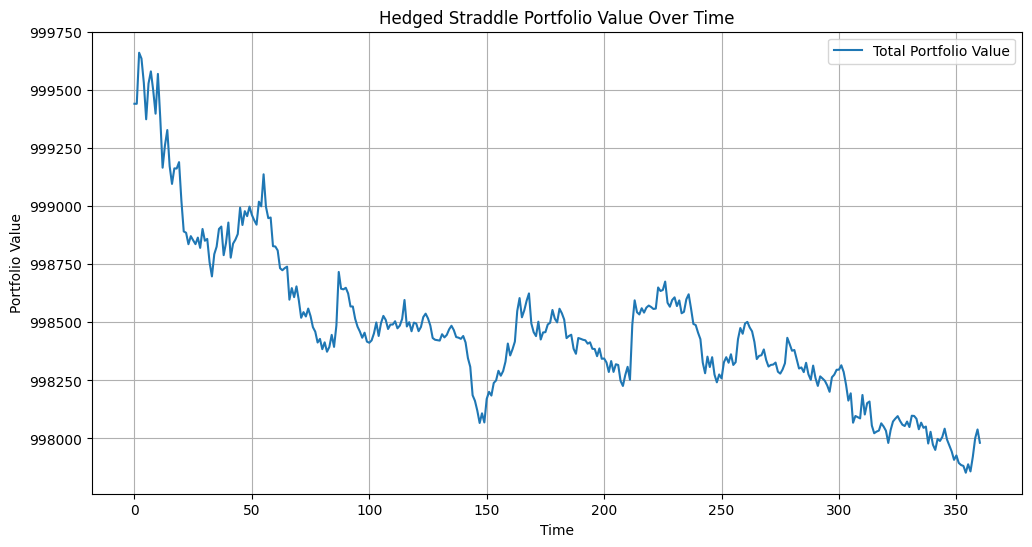

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(pnl_df.index, pnl_df['TotalValue'], label='Total Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Hedged Straddle Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Yearly backtest

In [32]:
def run_yearly_backtest(
    year,
    stocks,
    weights,
    lot_sizes,
    strategy,  # Initially added for "H1" and "H2"
    max_percent_loss,
    hedge_interval_minutes=5,
    initial_cash=1000000
):
    cash = initial_cash
    full_pnl_df = pd.DataFrame()
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)

    current_date = start_date
    while current_date <= end_date:
        # Skip weekends: weekday() returns 0 (Monday) to 6 (Sunday)
        if current_date.weekday() < 5:  # 0-4 are weekdays
            date_str = current_date.strftime('%Y%m%d')

            dfs = [read_csv_file(stock, date_str) for stock in stocks]

            if all(df is not None for df in dfs):
                print(f"Running backtest for date: {date_str}")
                try:
                    pnl_df, total_val, report = simulate_hedged_straddle_day(
                        dfs=dfs,
                        stocks=stocks,
                        weights=weights,
                        start_date=current_date,
                        hedge_interval_minutes=hedge_interval_minutes,
                        lot_sizes=lot_sizes,
                        strategy=strategy,
                        cash=cash,
                        r=0.06,
                        dividend_yield=0.0,
                        transaction_cost_per_unit=0.01,
                        option_transaction_cost=0.01
                    )
                    cash = report['final_cash']  # carry forward cash
                    pnl_df['Date'] = current_date.date()
                    full_pnl_df = pd.concat([full_pnl_df, pnl_df], ignore_index=True)

                    # Calculate exit threshold cash based on max_percent_loss
                    threshold_cash = initial_cash * (1 - max_percent_loss / 100)
                    if cash < threshold_cash:
                        print(f"Exiting early on {date_str} because cash dropped below {100 - max_percent_loss}% of initial amount.")
                        break

                except Exception as e:
                    print(f"Error on {date_str}: {e}")
            else:
                print(f"Data missing for one or more stocks on {date_str}")

        current_date += timedelta(days=1)

    return cash, full_pnl_df

## With H1

In [33]:
hedge_intervals = 5 # hedge interval in minutes
stocks = ["ASIANPAINT", "BAJAJ-AUTO", "BAJFINANCE", "HDFCBANK", "ICICIBANK", "RELIANCE", "SBIN", "TATAMOTORS", "TCS", "TITAN"] # Available "ASIANPAINT", "BAJAJ-AUTO", "BAJFINANCE", "HDFCBANK", "ICICIBANK", "RELIANCE", "SBIN", "TATAMOTORS", "TCS", "TITAN"
weight = [1/len(stocks)] * len(stocks) 
start_date = "20240101"

In [34]:
df = pd.read_csv('NIFTY_200_Lot_Size.csv')
df['Symbol'] = df['Symbol'].str.strip().str.upper()
df['LOT_SIZE'] = pd.to_numeric(df['LOT_SIZE'], errors='coerce')
lot_size_map = dict(zip(df['Symbol'], df['LOT_SIZE']))

lot_sizes = [lot_size_map.get(symbol.strip().upper()) for symbol in stocks]

In [35]:
final_cash_H1, yearly_pnl_H1 = run_yearly_backtest(
    year=2024,
    stocks=stocks,
    weights=weight,
    lot_sizes=lot_sizes,
    strategy="H1",
    max_percent_loss=25
)

Running backtest for date: 20240101
Error buying initial straddle for ASIANPAINT: (Timestamp('2024-01-01 09:16:00'), 'ASIANPAINT', 3420.0, 'PE')
Initial: Bought 7 BAJAJ-AUTO straddles at strike 6800.0 for 2956.10
Initial: Bought 12 BAJFINANCE straddles at strike 7350.0 for 5359.80
Initial: Bought 55 HDFCBANK straddles at strike 1710.0 for 4028.75
Initial: Bought 70 ICICIBANK straddles at strike 1000.0 for 3398.50
Initial: Bought 50 RELIANCE straddles at strike 2600.0 for 5885.00
Initial: Bought 75 SBIN straddles at strike 645.0 for 2865.00
Initial: Bought 55 TATAMOTORS straddles at strike 790.0 for 2950.75
Initial: Bought 17 TCS straddles at strike 3800.0 for 3717.05
Initial: Bought 17 TITAN straddles at strike 3700.0 for 3206.20
Final: Sold 7 BAJAJ-AUTO straddles for 2735.25, ITM loss: 352.31
Final: Sold 12 BAJFINANCE straddles for 4971.60, ITM loss: 116.04
Final: Sold 55 HDFCBANK straddles for 3792.25, ITM loss: 55.00
Final: Sold 70 ICICIBANK straddles for 3356.50, ITM loss: 466.90
F

In [44]:
yearly_pnl_H1.head()

,Timestamp,OptionValue,HedgeValue,Cash,TotalValue,PnL,Strategy,TotalPortfolioDelta,Date
0,2024-01-01 09:15:00,34140.775,-32742.909264,9.983556e+05,999753.504816,-246.495184,H1,None,2024-01-01
1,2024-01-01 09:20:00,34092.100,-28515.770030,9.941491e+05,999725.474954,-274.525046,H1,None,2024-01-01
2,2024-01-01 09:25:00,33794.350,-32416.384030,9.980245e+05,999402.418512,-597.581488,H1,None,2024-01-01
3,2024-01-01 09:30:00,33782.175,-28190.588419,9.938238e+05,999415.382797,-584.617203,H1,None,2024-01-01
4,2024-01-01 09:35:00,33772.900,-34826.245045,1.000430e+06,999376.391771,-623.608229,H1,None,2024-01-01


In [36]:
final_cash_H1

749333.8277782112

## Plots for H1

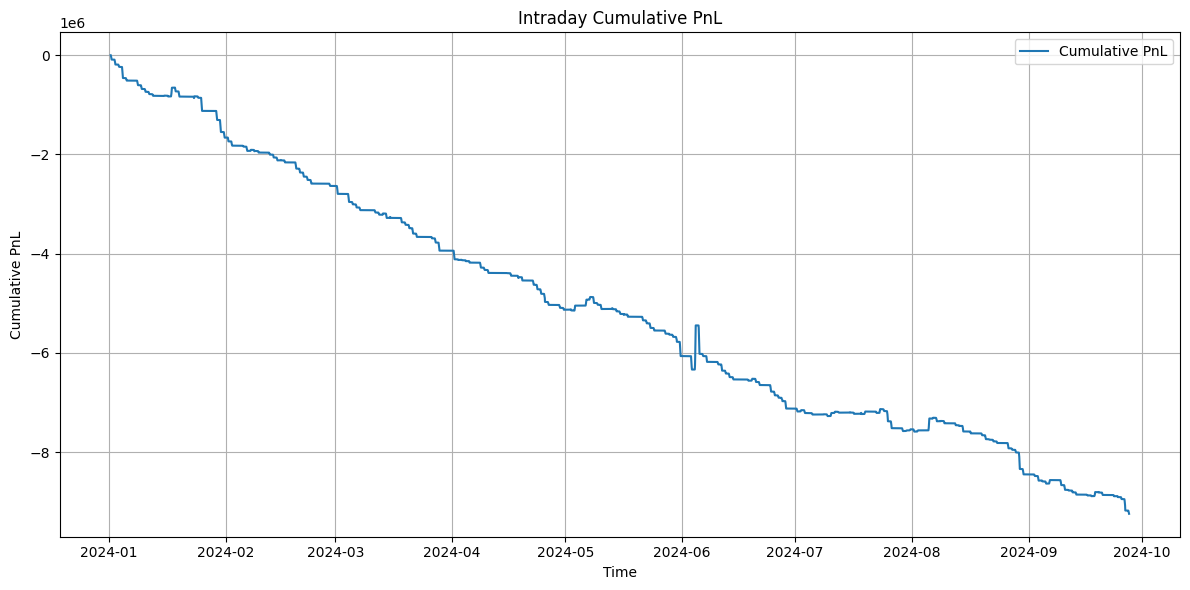

In [46]:
yearly_pnl_H1['Timestamp'] = pd.to_datetime(yearly_pnl_H1['Timestamp'])

yearly_pnl_H1['CumulativePnL'] = yearly_pnl_H1['PnL'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(yearly_pnl_H1['Timestamp'], yearly_pnl_H1['CumulativePnL'], label='Cumulative PnL')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.title('Intraday Cumulative PnL')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

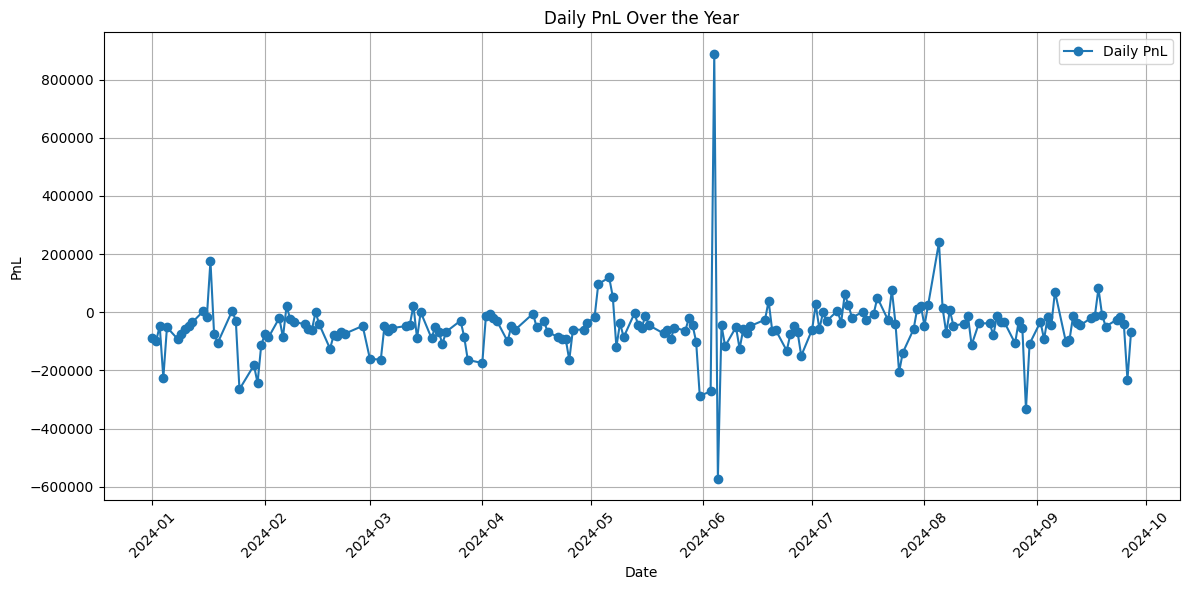

In [47]:
daily_pnl_H1 = yearly_pnl_H1.groupby('Date')['PnL'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_pnl_H1['Date'], daily_pnl_H1['PnL'], marker='o', label='Daily PnL')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.title('Daily PnL Over the Year')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
daily_pnl_H1['CumulativePnL'] = daily_pnl_H1['PnL'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(daily_pnl_H1['Date'], daily_pnl_H1['CumulativePnL'], color='green', label='Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL Over the Year')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## With H2

In [37]:
hedge_intervals = 5 # hedge interval in minutes
stocks = ["ASIANPAINT", "BAJAJ-AUTO", "BAJFINANCE", "HDFCBANK", "ICICIBANK", "RELIANCE", "SBIN", "TATAMOTORS", "TCS", "TITAN"] # Available "ASIANPAINT", "BAJAJ-AUTO", "BAJFINANCE", "HDFCBANK", "ICICIBANK", "RELIANCE", "SBIN", "TATAMOTORS", "TCS", "TITAN"
weight = [1/len(stocks)] * len(stocks) #
start_date = "20240101"

In [38]:
df = pd.read_csv('NIFTY_200_Lot_Size.csv')
df['Symbol'] = df['Symbol'].str.strip().str.upper()
df['LOT_SIZE'] = pd.to_numeric(df['LOT_SIZE'], errors='coerce')
lot_size_map = dict(zip(df['Symbol'], df['LOT_SIZE']))

lot_sizes = [lot_size_map.get(symbol.strip().upper()) for symbol in stocks]

In [39]:
final_cash, yearly_pnl = run_yearly_backtest(
    year=2024,
    stocks=stocks,
    weights=weight,
    lot_sizes=lot_sizes,
    strategy="H2",
    max_percent_loss=25
)

Running backtest for date: 20240101
Error buying initial straddle for ASIANPAINT: (Timestamp('2024-01-01 09:16:00'), 'ASIANPAINT', 3420.0, 'PE')
Initial: Bought 7 BAJAJ-AUTO straddles at strike 6800.0 for 2956.10
Initial: Bought 12 BAJFINANCE straddles at strike 7350.0 for 5359.80
Initial: Bought 55 HDFCBANK straddles at strike 1710.0 for 4028.75
Initial: Bought 70 ICICIBANK straddles at strike 1000.0 for 3398.50
Initial: Bought 50 RELIANCE straddles at strike 2600.0 for 5885.00
Initial: Bought 75 SBIN straddles at strike 645.0 for 2865.00
Initial: Bought 55 TATAMOTORS straddles at strike 790.0 for 2950.75
Initial: Bought 17 TCS straddles at strike 3800.0 for 3717.05
Initial: Bought 17 TITAN straddles at strike 3700.0 for 3206.20
Final: Sold 7 BAJAJ-AUTO straddles for 2735.25, ITM loss: 352.31
Final: Sold 12 BAJFINANCE straddles for 4971.60, ITM loss: 116.04
Final: Sold 55 HDFCBANK straddles for 3792.25, ITM loss: 55.00
Final: Sold 70 ICICIBANK straddles for 3356.50, ITM loss: 466.90
F

In [51]:
final_cash_H2 = final_cash
yearly_pnl_H2 = yearly_pnl

In [99]:
yearly_pnl_H2.head()

,Timestamp,OptionValue,HedgeValue,Cash,TotalValue,PnL,Strategy,TotalPortfolioDelta,Date,CumulativePnL
0,2024-01-01 09:15:00,34140.775,-47950.007263,1.013555e+06,999745.918140,-254.081860,H2,16.872909,2024-01-01,-254.081860
1,2024-01-01 09:20:00,34092.100,-61281.700747,1.026923e+06,999733.269473,-266.730527,H2,21.583383,2024-01-01,-520.812387
2,2024-01-01 09:25:00,33794.350,-71331.474408,1.036963e+06,999426.126656,-573.873344,H2,25.121130,2024-01-01,-1094.685731
3,2024-01-01 09:30:00,33782.175,-61415.538895,1.027029e+06,999395.591099,-604.408901,H2,21.624938,2024-01-01,-1699.094632
4,2024-01-01 09:35:00,33772.900,-74628.040653,1.040194e+06,999339.336174,-660.663826,H2,26.259920,2024-01-01,-2359.758458


In [52]:
final_cash_H2

748028.9602702371

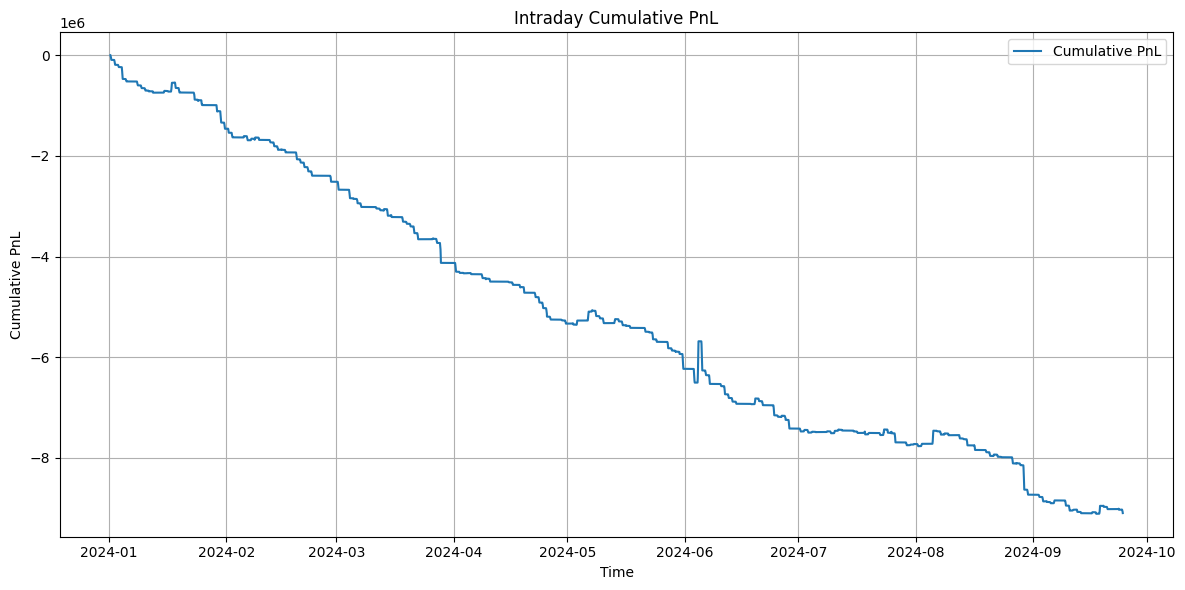

In [49]:
yearly_pnl['Timestamp'] = pd.to_datetime(yearly_pnl['Timestamp'])

yearly_pnl['CumulativePnL'] = yearly_pnl['PnL'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(yearly_pnl['Timestamp'], yearly_pnl['CumulativePnL'], label='Cumulative PnL')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.title('Intraday Cumulative PnL')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

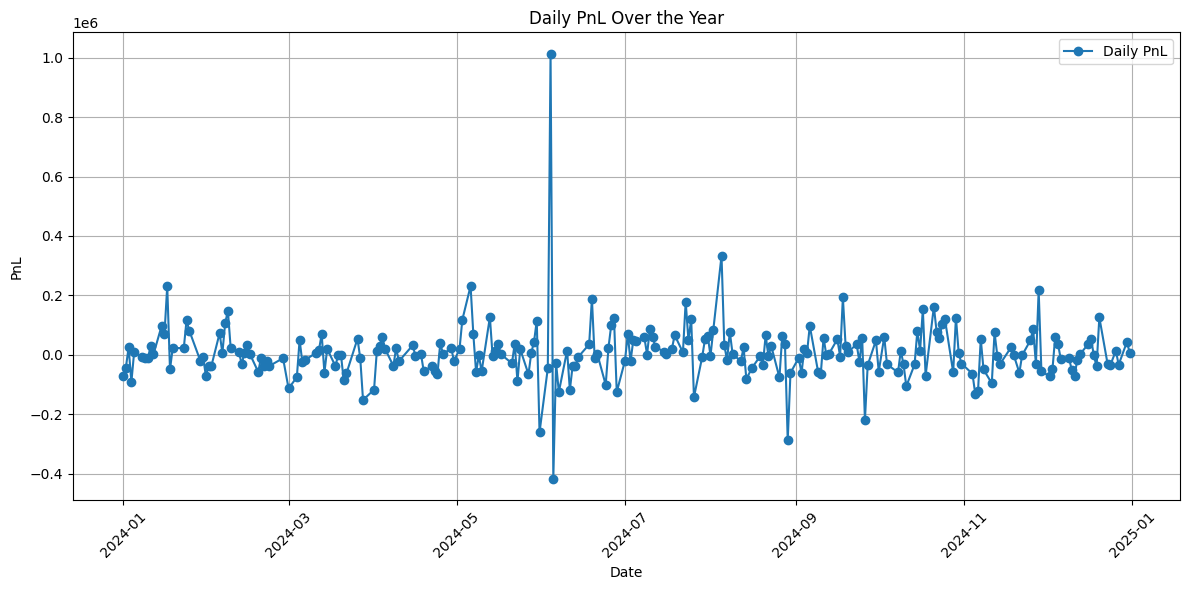

In [103]:
daily_pnl = yearly_pnl.groupby('Date')['PnL'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_pnl['Date'], daily_pnl['PnL'], marker='o', label='Daily PnL')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.title('Daily PnL Over the Year')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

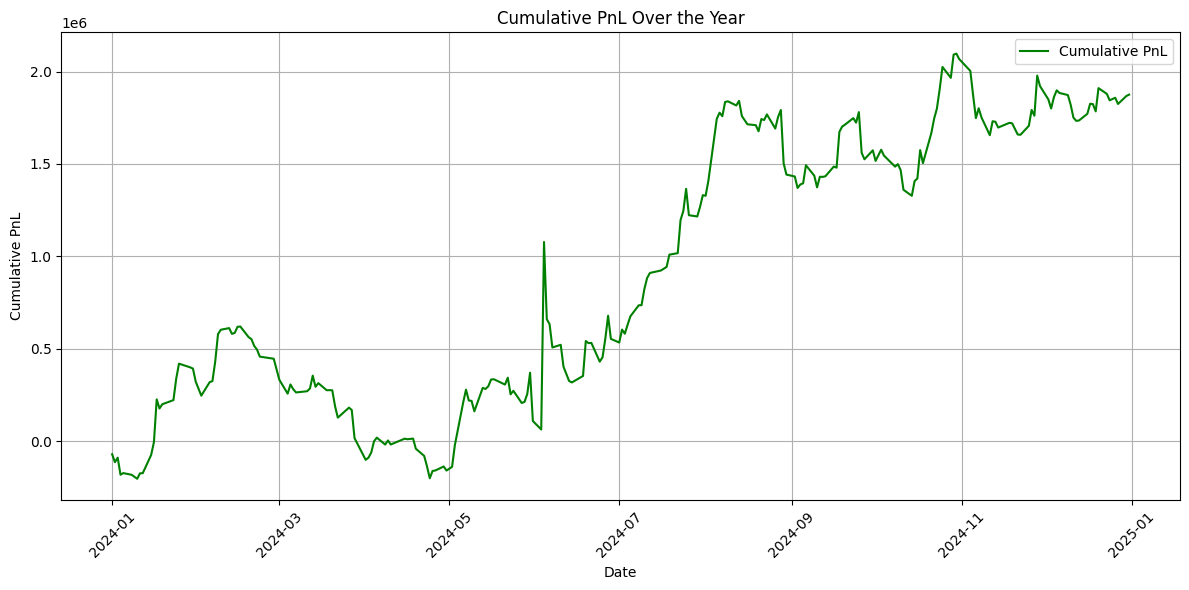

In [104]:
daily_pnl['CumulativePnL'] = daily_pnl['PnL'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(daily_pnl['Date'], daily_pnl['CumulativePnL'], color='green', label='Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL Over the Year')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [64]:
daily_H1 = yearly_pnl_H1.groupby('Date')['TotalValue'].last().pct_change()

daily_H2 = yearly_pnl_H2.groupby('Date')['TotalValue'].last().pct_change()

daily_returns = pd.DataFrame({
    'H1': daily_H1,
    'H2': daily_H2
})

/home/cloudcraftz/Aman_codes/eis_env/lib/python3.8/site-packages/pandas/core/indexes/base.py:358: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_ndarray, lidx, ridx = libjoin.outer_join_indexer(sv, ov)
/home/cloudcraftz/Aman_codes/eis_env/lib/python3.8/site-packages/pandas/core/indexes/base.py:3809: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = self._engine.get_indexer(tgt_values)


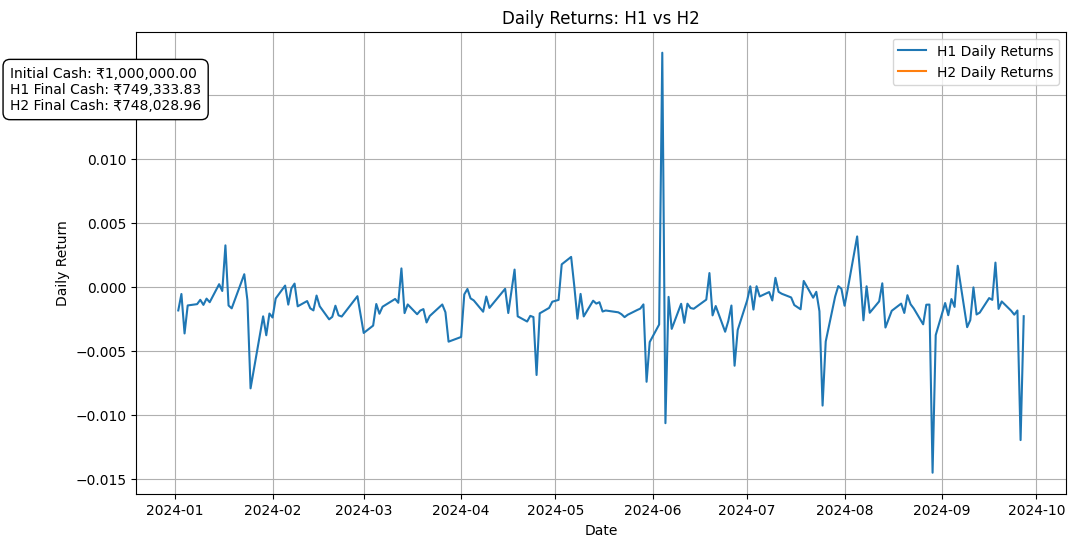

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(daily_returns.index, daily_returns['H1'], label='H1 Daily Returns')
plt.plot(daily_returns.index, daily_returns['H2'], label='H2 Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns: H1 vs H2')
plt.legend()
plt.grid(True)

summary_text = (
    f"Initial Cash: ₹{1000000:,.2f}\n"
    f"H1 Final Cash: ₹{final_cash_H1:,.2f}\n"
    f"H2 Final Cash: ₹{final_cash_H2:,.2f}"
)

plt.gcf().text(0.02, 0.75, summary_text, fontsize=10,
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.show()

In [66]:
daily_total_H1 = yearly_pnl_H1.groupby('Date')['TotalValue'].last()
daily_total_H2 = yearly_pnl_H2.groupby('Date')['TotalValue'].last()

In [67]:
yearly_pnl_H1['Timestamp'] = pd.to_datetime(yearly_pnl_H1['Timestamp'])
yearly_pnl_H2['Timestamp'] = pd.to_datetime(yearly_pnl_H2['Timestamp'])

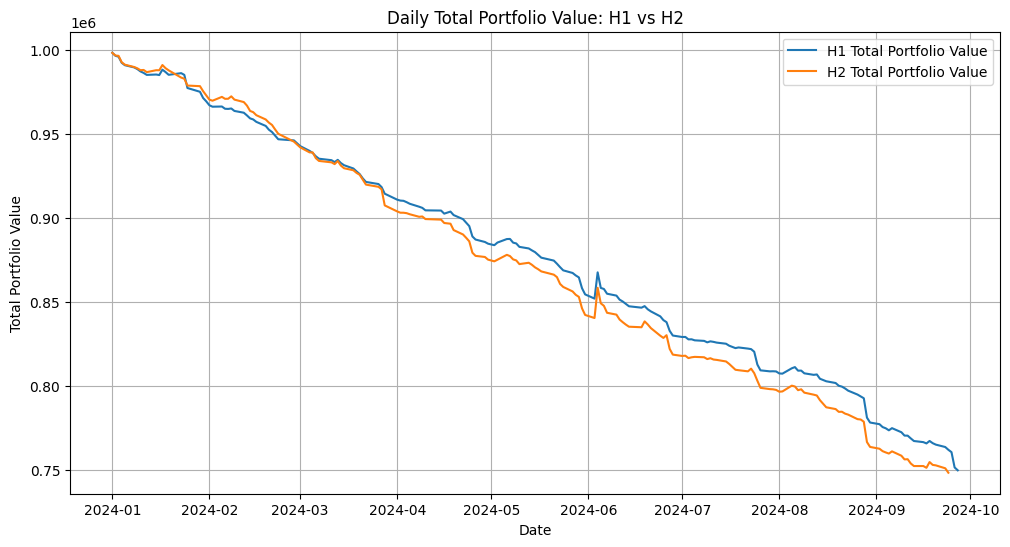

In [68]:
plt.figure(figsize=(12,6))
plt.plot(daily_total_H1.index, daily_total_H1.values, label='H1 Total Portfolio Value')
plt.plot(daily_total_H2.index, daily_total_H2.values, label='H2 Total Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Total Portfolio Value')
plt.title('Daily Total Portfolio Value: H1 vs H2')
plt.legend()
plt.grid(True)
plt.show()